<a href="https://colab.research.google.com/github/PioDru/colab/blob/main/chest_xray_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

#print("Path to dataset files:", path)

In [30]:
#!/bin/bash
!curl -L -o ./chest-xray-pneumonia.zip https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2349M  100 2349M    0     0   164M      0  0:00:14  0:00:14 --:--:--  227M


In [31]:
!unzip -q ./chest-xray-pneumonia.zip  -d chest-xray-pneumonia

replace chest-xray-pneumonia/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import glob

# Ustawienia ścieżek do danych – upewnij się, że struktura katalogów jest następująca:
# dataset/
# ├── train/
# │   ├── NORMAL/
# │   └── PNEUMONIA/
# ├── validation/
# │   ├── NORMAL/
# │   └── PNEUMONIA/
# └── test/
#     ├── NORMAL/
#     └── PNEUMONIA/
base_dir = '/content/chest-xray-pneumonia/chest_xray'  # np. './chest_xray'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Parametry przetwarzania obrazów
img_width, img_height = 150, 150  # rozmiar wejściowy obrazu
batch_size = 32

# Przygotowanie generatorów danych z augmentacją dla treningu
train_datagen = ImageDataGenerator(
    rescale=1./255,          # normalizacja pikseli
    rotation_range=15,       # losowe obroty
    width_shift_range=0.15,   # przesunięcia w poziomie
    height_shift_range=0.15,  # przesunięcia w pionie
    shear_range=0.15,         # transformacja skośna
    zoom_range=0.15,          # powiększenia
    horizontal_flip=False,    # odbicie lustrzane
    vertical_flip=False,
    fill_mode='nearest'
)

# Dla zbiorów walidacyjnego i testowego używamy tylko skalowania
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generatory danych
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = True,               # True - zdjęcia będą losowo mieszane w całym zbiorze
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
)

# Budowa modelu CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # klasyfikacja binarna
])

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=4,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)

model_checkpoint = ModelCheckpoint(
    filepath='pneumonia_classification_model.keras',  # Use .keras extension
    monitor='val_accuracy',       # Metric to monitor
    save_best_only=True,          # Save only the best model
    mode='max'                    # Maximize the monitored metric
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,          # Reduce learning rate by a factor of 0.1
    patience=3           # Number of epochs to wait before reducing LR
)

# Kompilacja modelu
model.compile(
    loss='binary_crossentropy',
    #optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Wyświetlenie podsumowania modelu
model.summary()

# Trening modelu
epochs = 30 #20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Add callbacks here
)

# Ewaluacja na zbiorze testowym
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Dokładność na zbiorze testowym:', test_accuracy)

# Zapisanie modelu do pliku
model.save('pneumonia_classification_model.keras')
pretrained_model = tf.keras.applications.MobileNet()
tf.saved_model.save(pretrained_model, 'pneumonia_classification_model/mobilenet/1/')
#model_summary(model, X_val_bal, y_val_bal)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       6,423,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,927,041 (26.42 MB)

 Trainable params: 6,927,041 (26.42 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 415ms/step - accuracy: 0.7454 - loss: 0.5667 - val_accuracy: 0.6250 - val_loss: 0.6743 - learning_rate: 1.0000e-04
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 416ms/step - accuracy: 0.8385 - loss: 0.3466 - val_accuracy: 0.5000 - val_loss: 0.8306 - learning_rate: 1.0000e-04
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 407ms/step - accuracy: 0.8744 - loss: 0.2900 - val_accuracy: 0.6250 - val_loss: 0.7916 - learning_rate: 1.0000e-04
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 411ms/step - accuracy: 0.8739 - loss: 0.2800 - val_accuracy: 0.8125 - val_loss: 0.4193 - learning_rate: 1.0000e-04
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 413ms/step - accuracy: 0.8762 - loss: 0.2795 - val_accuracy: 0.8125 - val_loss: 0.4176 - learning_rate: 1.0000e-04
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 418ms/step - accuracy: 0.8946 - loss: 0.2496 - val_accuracy: 0.6250 - val_loss: 0.5874 - learning_rate: 1.0000e-04
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 41

Liczba obrazów w poszczególnych zbiorach:
train: {'NORMAL': 1341, 'PNEUMONIA': 3875}
val: {'NORMAL': 8, 'PNEUMONIA': 8}
test: {'NORMAL': 234, 'PNEUMONIA': 390}


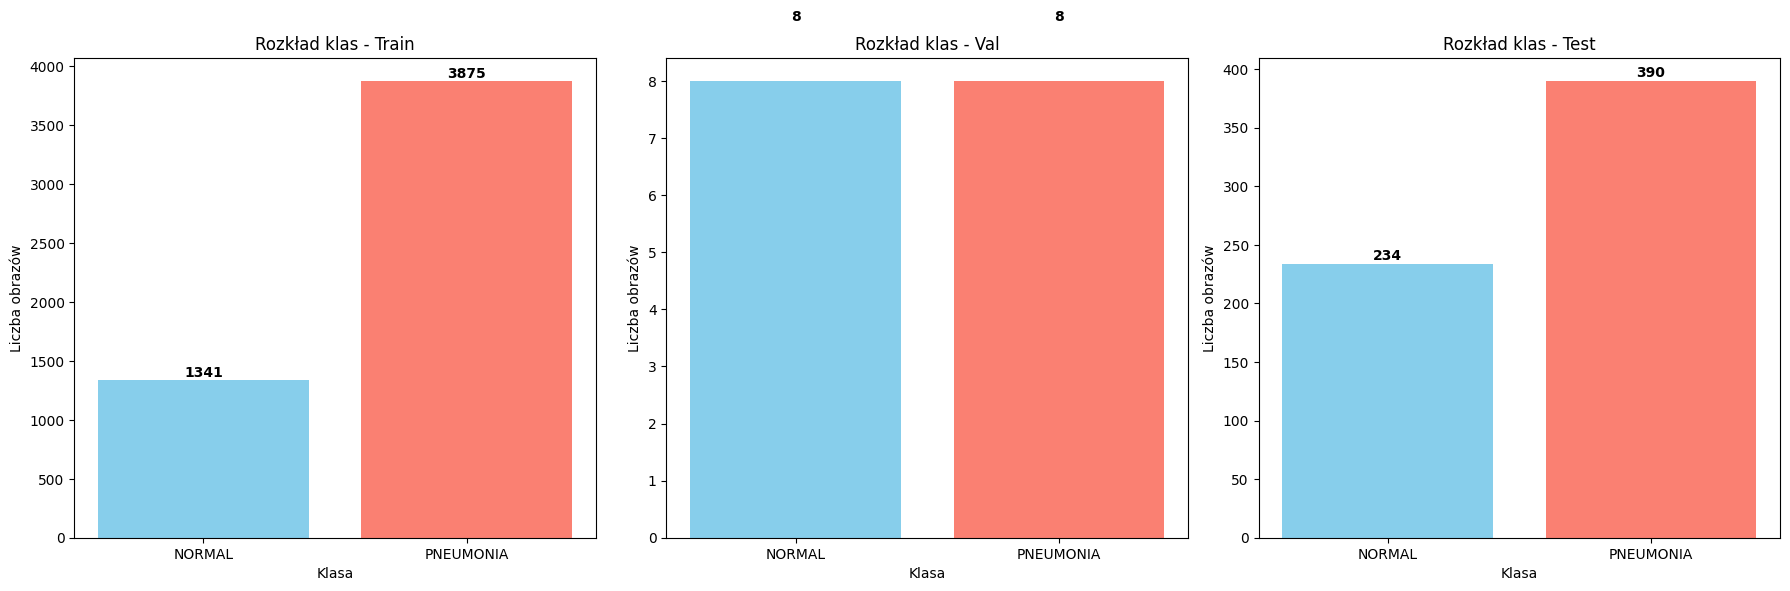

In [45]:
#wykresy zawartosci oryginalnych danych
import os
import matplotlib.pyplot as plt

# Ustaw ścieżkę do głównego folderu ze zbiorem danych
base_dir = '/content/chest-xray-pneumonia/chest_xray'

subsets = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

# Słownik do przechowywania liczby obrazów dla każdej klasy w każdym zbiorze
counts = {}

for subset in subsets:
    counts[subset] = {}
    for cls in classes:
        folder = os.path.join(base_dir, subset, cls)
        if os.path.exists(folder):
            # Liczymy tylko pliki z rozszerzeniami obrazów
            num_files = len([f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            counts[subset][cls] = num_files
        else:
            counts[subset][cls] = 0

print("Liczba obrazów w poszczególnych zbiorach:")
for subset in counts:
    print(f"{subset}: {counts[subset]}")

# Generowanie wykresów słupkowych dla każdego zbioru
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, subset in zip(axes, subsets):
    cls_names = list(counts[subset].keys())
    cls_counts = list(counts[subset].values())

    bars = ax.bar(cls_names, cls_counts, color=['skyblue', 'salmon'])
    ax.set_title(f'Rozkład klas - {subset.capitalize()}')
    ax.set_xlabel('Klasa')
    ax.set_ylabel('Liczba obrazów')

    # Dodaj etykiety z liczbą obrazów nad słupkami
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 1, str(height),
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


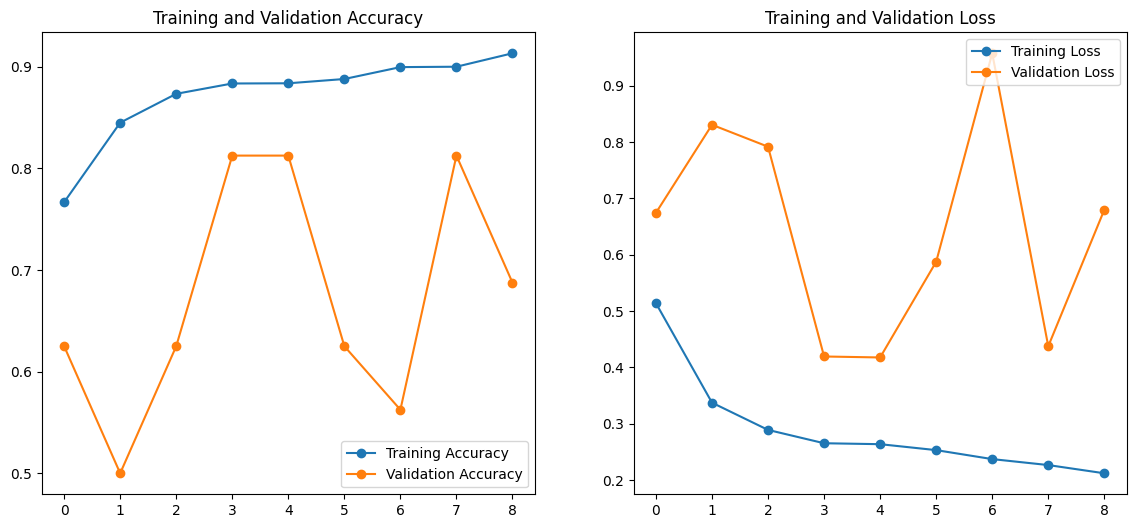

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.9038 - loss: 0.3082
Test Accuracy: 84.78%
Test Loss: 0.3503
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step
Confusion Matrix:
[[221  13]
 [ 82 308]]


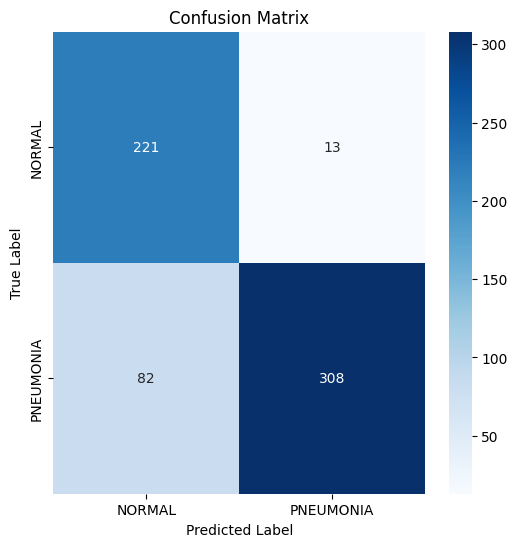

accuracy: 0.8478
recall: 0.7897
precision: 0.9595
f1: 0.8664
roc_auc: 0.8671


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Zakładamy, że obiekt `history` został zwrócony przez model.fit
# history = model.fit(...)

# Wykres accuracy i loss dla danych treningowych oraz walidacyjnych
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# Ocena modelu na zbiorze testowym
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test Loss: {:.4f}".format(test_loss))

# Obliczenie macierzy pomyłek
# Upewnij się, że test_generator nie miesza kolejności, resetujemy go
test_generator.reset()
predictions = model.predict(test_generator)
# Zakładamy, że mamy klasyfikację binarną z funkcją aktywacji sigmoid
y_pred = (predictions > 0.5).astype(int).ravel()
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(6, 6))
class_names = list(test_generator.class_indices.keys())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print('accuracy: {:.4f}'.format(accuracy_score(y_true, y_pred)))
print('recall: {:.4f}'.format(recall_score(y_true, y_pred)))
print('precision: {:.4f}'.format(precision_score(y_true, y_pred)))
print('f1: {:.4f}'.format(f1_score(y_true, y_pred)))
print('roc_auc: {:.4f}'.format(roc_auc_score(y_true, y_pred)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0.8444433]]
0.8444433
Predykcja (prawdopodobieństwo Pneumonii): 0.8444433
Wynik: Pneumonia


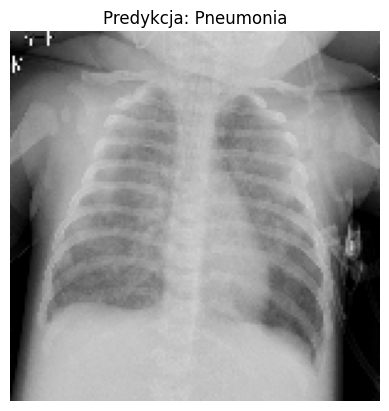

In [35]:
import keras
from keras import ops
from keras import utils
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Ścieżka do wybranego obrazu z zestawu danych
sample_image_path = '/content/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg'

# Wczytanie obrazu i przeskalowanie do wymiarów modelu
sample_img = keras.utils.load_img(sample_image_path, target_size=(img_width, img_height))
sample_img_array = keras.utils.img_to_array(sample_img)
sample_img_array = np.expand_dims(sample_img_array, axis=0)
sample_img_array /= 255.0

# Predykcja dla wybranego obrazu
prediction = model.predict(sample_img_array)[0][0]
print( model.predict(sample_img_array))
print(prediction)
print("Predykcja (prawdopodobieństwo Pneumonii):", prediction)
if prediction > 0.5:
    print("Wynik: Pneumonia")
else:
    print("Wynik: Normal")

# Wyświetlenie obrazu wraz z wynikową predykcją
plt.imshow(sample_img)
plt.title("Predykcja: " + ("Pneumonia" if prediction > 0.5 else "Normal"))
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.24392982]]
0.24392982
Predykcja (prawdopodobieństwo Pneumonii): 0.24392982
Wynik: Normal


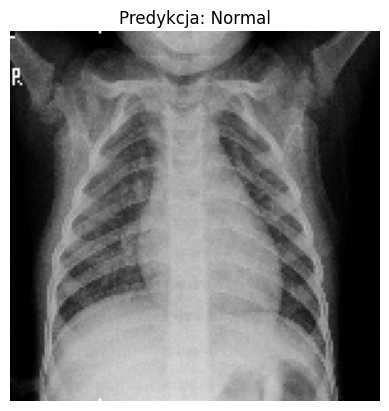

In [36]:
import keras
from keras import ops
from keras import utils
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# Ścieżka do wybranego obrazu z zestawu danych
sample_image_path = '/content/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg'

# Wczytanie obrazu i przeskalowanie do wymiarów modelu
sample_img = keras.utils.load_img(sample_image_path, target_size=(img_width, img_height))
sample_img_array = keras.utils.img_to_array(sample_img)
sample_img_array = np.expand_dims(sample_img_array, axis=0)
sample_img_array /= 255.0

# Predykcja dla wybranego obrazu
prediction = model.predict(sample_img_array)[0][0]
print( model.predict(sample_img_array))
print(prediction)
print("Predykcja (prawdopodobieństwo Pneumonii):", prediction)
if prediction > 0.5:
    print("Wynik: Pneumonia")
else:
    print("Wynik: Normal")

# Wyświetlenie obrazu wraz z wynikową predykcją
plt.imshow(sample_img)
plt.title("Predykcja: " + ("Pneumonia" if prediction > 0.5 else "Normal"))
plt.axis('off')
plt.show()

In [37]:
!zip -q -r 'pneumonia_classification_model.zip' 'pneumonia_classification_model'

In [38]:
import tempfile

MODEL_DIR = '/content/model/'#tempfile.gettempdir()
MODEL_NAME = 'pneumonia_classification_model'
version = 1
export_path = os.path.join(MODEL_DIR, MODEL_NAME, str(version))
print('export_path = {}\n'.format(export_path))

# Use tf.saved_model.save to export a SavedModel
tf.saved_model.save(
    model,
    export_path
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /content/model/pneumonia_classification_model/1


Saved model:
total 176
drwxr-xr-x 2 root root   4096 Feb 19 18:39 assets
-rw-r--r-- 1 root root     55 Feb 19 18:39 fingerprint.pb
-rw-r--r-- 1 root root 167305 Feb 19 18:39 saved_model.pb
drwxr-xr-x 2 root root   4096 Feb 19 18:39 variables


In [ ]:
'''
import base64

# Ścieżka do wybranego obrazu z zestawu danych
sample_image_path = '/content/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg'  # zamień na faktyczną ścieżkę

# Wczytanie obrazu i przeskalowanie do wymiarów modelu
sample_img = keras.utils.load_img(sample_image_path, target_size=(img_width, img_height))

with open(sample_image_path, "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())

print(encoded_string)
'''

Łączna liczba obrazów przed balansowaniem: 5856
label
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64

Liczba obrazów po balansowaniu:
label
NORMAL       1583
PNEUMONIA    1583
Name: count, dtype: int64

Liczba próbek w nowych zbiorach:
Trening: 2216
Walidacja: 475
Test: 475


<ipython-input-40-20e08d12f75b>:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min_count, random_state=42))


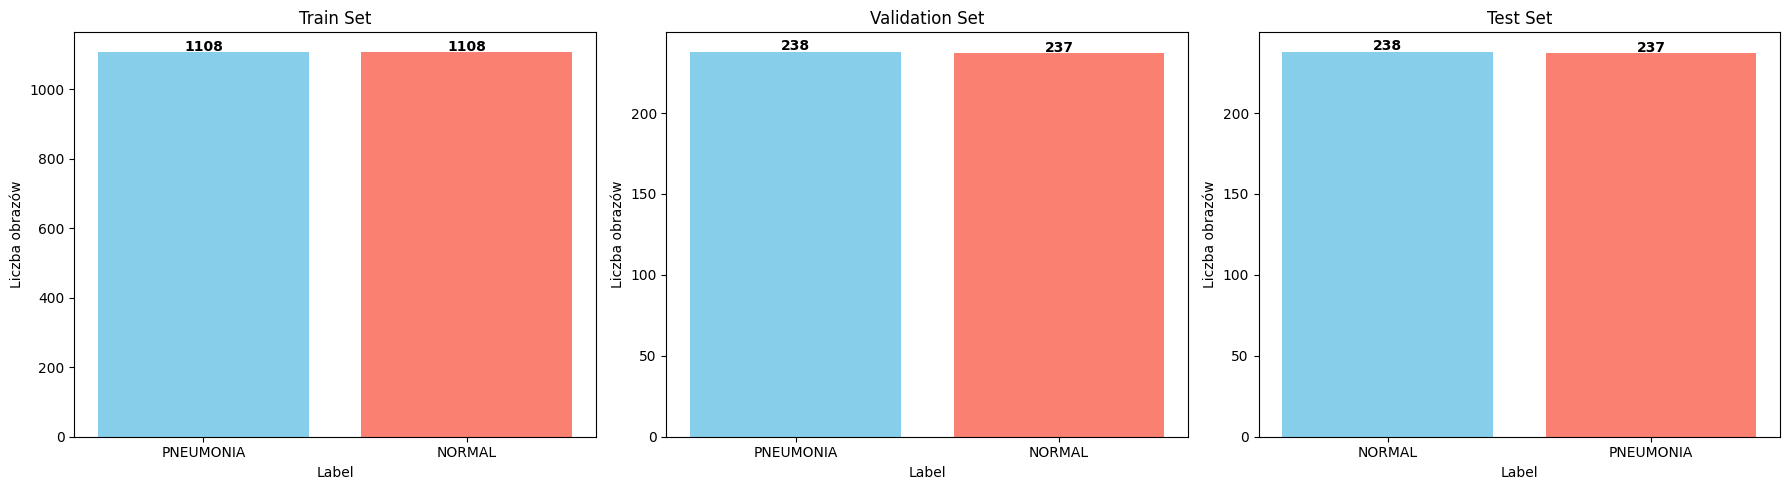

In [40]:
#tworzenie nowych, zbalansowanych danych treningowych, testowych i walidacyjnych

import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def get_image_paths(base_dir, subsets=['train', 'test', 'val'], classes=['NORMAL', 'PNEUMONIA']):
    #Przegląda podfoldery i zbiera ścieżki do obrazów oraz odpowiadające im etykiety
    image_paths = []
    labels = []
    for subset in subsets:
        for cls in classes:
            folder = os.path.join(base_dir, subset, cls)
            if not os.path.exists(folder):
                print(f"Folder {folder} nie istnieje, pomijam.")
                continue
            for fname in os.listdir(folder):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(folder, fname))
                    labels.append(cls)
    return pd.DataFrame({'filepath': image_paths, 'label': labels})

# Ścieżka do głównego folderu z danymi (zmień na swoją)
base_dir = '/content/chest-xray-pneumonia/chest_xray'

# Połącz wszystkie podzbiory
df = get_image_paths(base_dir, subsets=['train', 'test', 'val'])

print("Łączna liczba obrazów przed balansowaniem:", len(df))
print(df['label'].value_counts())

# Balansowanie: dla każdej klasy wybieramy tyle próbek, ile wynosi liczba obrazów w mniejszej klasie
min_count = df['label'].value_counts().min()
df_balanced = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min_count, random_state=42))

print("\nLiczba obrazów po balansowaniu:")
print(df_balanced['label'].value_counts())

# Losowe przetasowanie całego zbioru
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Podział na nowe zbiory: 70% trening, 15% walidacja, 15% test
train_df, temp_df = train_test_split(df_balanced, test_size=0.3, random_state=42, stratify=df_balanced['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print("\nLiczba próbek w nowych zbiorach:")
print("Trening:", len(train_df))
print("Walidacja:", len(val_df))
print("Test:", len(test_df))

# Opcjonalnie: zapisanie podziału do plików CSV
train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)

# Generowanie wykresów obrazujących rozkład klas w poszczególnych zbiorach
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
datasets = [('Train', train_df), ('Validation', val_df), ('Test', test_df)]

for ax, (title, dataset) in zip(axs, datasets):
    counts = dataset['label'].value_counts()
    ax.bar(counts.index, counts.values, color=['skyblue', 'salmon'])
    ax.set_title(f'{title} Set')
    ax.set_xlabel('Label')
    ax.set_ylabel('Liczba obrazów')
    # Dodanie liczby nad słupkami
    for i, v in enumerate(counts.values):
        ax.text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [46]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import glob

# Ustawienia ścieżek do danych – upewnij się, że struktura katalogów jest następująca:
# dataset/
# ├── train/
# │   ├── NORMAL/
# │   └── PNEUMONIA/
# ├── validation/
# │   ├── NORMAL/
# │   └── PNEUMONIA/
# └── test/
#     ├── NORMAL/
#     └── PNEUMONIA/
base_dir = '/content/chest-xray-pneumonia/chest_xray'  # np. './chest_xray'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Parametry przetwarzania obrazów
img_width, img_height = 150, 150  # rozmiar wejściowy obrazu
batch_size = 32

# Przygotowanie generatorów danych z augmentacją dla treningu
train_datagen = ImageDataGenerator(
    rescale=1./255,          # normalizacja pikseli
    rotation_range=15,       # losowe obroty
    width_shift_range=0.15,   # przesunięcia w poziomie
    height_shift_range=0.15,  # przesunięcia w pionie
    shear_range=0.15,         # transformacja skośna
    zoom_range=0.15,          # powiększenia
    horizontal_flip=False,    # odbicie lustrzane
    vertical_flip=False,
    fill_mode='nearest'
)

# Dla zbiorów walidacyjnego i testowego używamy tylko skalowania
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generatory danych
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",  # Specify the column containing image paths
    y_col="label",  # Specify the column containing labels
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = True,               # True - zdjęcia będą losowo mieszane w całym zbiorze
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",  # Specify the column containing image paths
    y_col="label",  # Specify the column containing labels
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filepath",  # Specify the column containing image paths
    y_col="label",  # Specify the column containing labels
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
)

# Budowa modelu CNN
model_bal = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # klasyfikacja binarna
])

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    #patience=4,          # Number of epochs to wait before stopping
    patience=5,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)

model_checkpoint = ModelCheckpoint(
    filepath='pneumonia_classification_model_bal.keras',  # Use .keras extension
    monitor='val_accuracy',       # Metric to monitor
    save_best_only=True,          # Save only the best model
    mode='max'                    # Maximize the monitored metric
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,          # Reduce learning rate by a factor of 0.1
    #patience=3           # Number of epochs to wait before reducing LR
    patience=5           # Number of epochs to wait before reducing LR
)

# Kompilacja modelu
model_bal.compile(
    loss='binary_crossentropy',
    #optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Wyświetlenie podsumowania modelu
model_bal.summary()

# Trening modelu
epochs = 30 #20
history = model_bal.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Add callbacks here
)

# Ewaluacja na zbiorze testowym
test_loss, test_accuracy = model_bal.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Dokładność na zbiorze testowym:', test_accuracy)

# Zapisanie modelu do pliku
model_bal.save('pneumonia_classification_model_bal.keras')
#model_summary(model_bal, X_val_bal, y_val_bal)

Found 2216 validated image filenames belonging to 2 classes.
Found 475 validated image filenames belonging to 2 classes.
Found 475 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │       6,423,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,927,041 (26.42 MB)

 Trainable params: 6,927,041 (26.42 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 48s 631ms/step - accuracy: 0.5182 - loss: 0.6836 - val_accuracy: 0.8259 - val_loss: 0.5575 - learning_rate: 1.0000e-04
Epoch 2/30
 1/69 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6250 - loss: 0.6017

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6250 - loss: 0.6017 - val_accuracy: 0.7411 - val_loss: 0.5807 - learning_rate: 1.0000e-04
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 43s 625ms/step - accuracy: 0.7019 - loss: 0.5902 - val_accuracy: 0.8058 - val_loss: 0.4382 - learning_rate: 1.0000e-04
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.8125 - loss: 0.3919 - val_accuracy: 0.7857 - val_loss: 0.4697 - learning_rate: 1.0000e-04
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 592ms/step - accuracy: 0.7977 - loss: 0.4560 - val_accuracy: 0.8259 - val_loss: 0.3978 - learning_rate: 1.0000e-04
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.8125 - loss: 0.3888 - val_accuracy: 0.8817 - val_loss: 0.3265 - learning_rate: 1.0000e-04
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 74s 562ms/step - accuracy: 0.8221 - loss: 0.4152 - val_accuracy: 0.8348 - val_loss: 0.4014 - learning_rate: 1.0000e-04
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.7812 - lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[[0.9753914]]
0.9753914
Predykcja (prawdopodobieństwo Pneumonii): 0.9753914
Wynik: Pneumonia


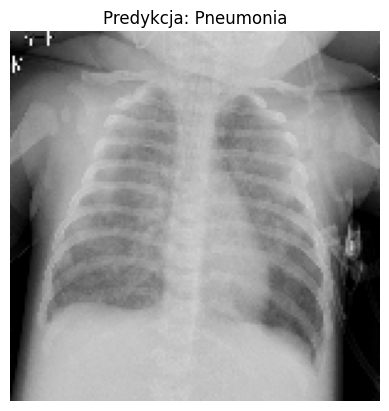

In [47]:
import keras
from keras import ops
from keras import utils
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Ścieżka do wybranego obrazu z zestawu danych
sample_image_path = '/content/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg'

# Wczytanie obrazu i przeskalowanie do wymiarów modelu
sample_img = keras.utils.load_img(sample_image_path, target_size=(img_width, img_height))
sample_img_array = keras.utils.img_to_array(sample_img)
sample_img_array = np.expand_dims(sample_img_array, axis=0)
sample_img_array /= 255.0

# Predykcja dla wybranego obrazu
prediction = model_bal.predict(sample_img_array)[0][0]
print( model_bal.predict(sample_img_array))
print(prediction)
print("Predykcja (prawdopodobieństwo Pneumonii):", prediction)
if prediction > 0.5:
    print("Wynik: Pneumonia")
else:
    print("Wynik: Normal")

# Wyświetlenie obrazu wraz z wynikową predykcją
plt.imshow(sample_img)
plt.title("Predykcja: " + ("Pneumonia" if prediction > 0.5 else "Normal"))
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[[0.54072964]]
0.54072964
Predykcja (prawdopodobieństwo Pneumonii): 0.54072964
Wynik: Pneumonia


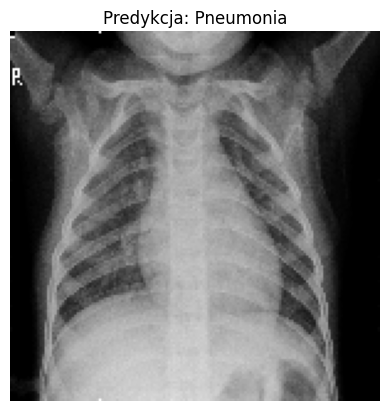

In [49]:
import keras
from keras import ops
from keras import utils
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Ścieżka do wybranego obrazu z zestawu danych
sample_image_path = '/content/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg'

# Wczytanie obrazu i przeskalowanie do wymiarów modelu
sample_img = keras.utils.load_img(sample_image_path, target_size=(img_width, img_height))
sample_img_array = keras.utils.img_to_array(sample_img)
sample_img_array = np.expand_dims(sample_img_array, axis=0)
sample_img_array /= 255.0

# Predykcja dla wybranego obrazu
prediction = model_bal.predict(sample_img_array)[0][0]
print( model_bal.predict(sample_img_array))
print(prediction)
print("Predykcja (prawdopodobieństwo Pneumonii):", prediction)
if prediction > 0.5:
    print("Wynik: Pneumonia")
else:
    print("Wynik: Normal")

# Wyświetlenie obrazu wraz z wynikową predykcją
plt.imshow(sample_img)
plt.title("Predykcja: " + ("Pneumonia" if prediction > 0.5 else "Normal"))
plt.axis('off')
plt.show()

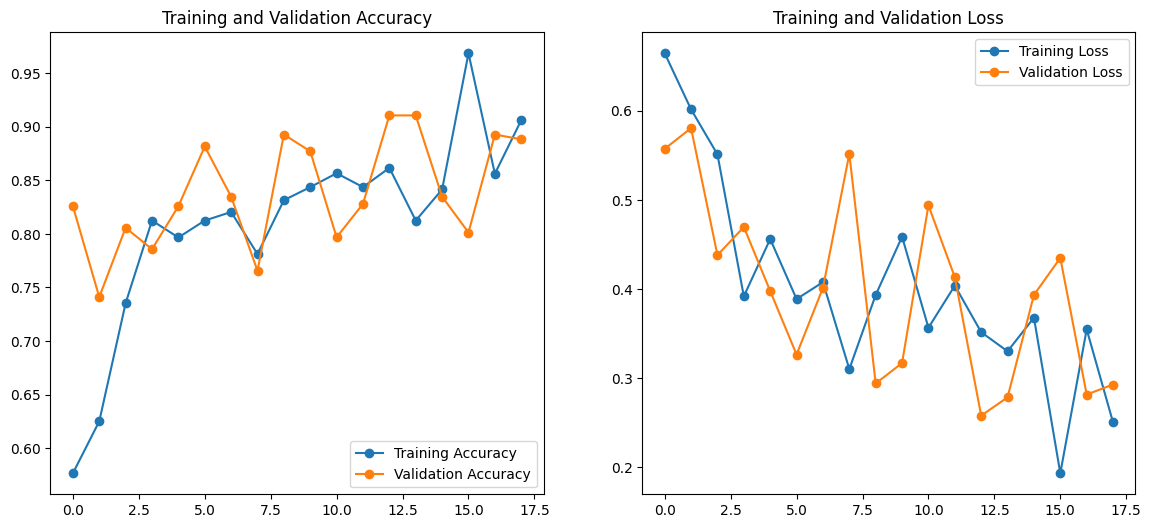

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step - accuracy: 0.9221 - loss: 0.2243
Test Accuracy: 90.32%
Test Loss: 0.2468
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step
Confusion Matrix:
[[216  22]
 [ 24 213]]


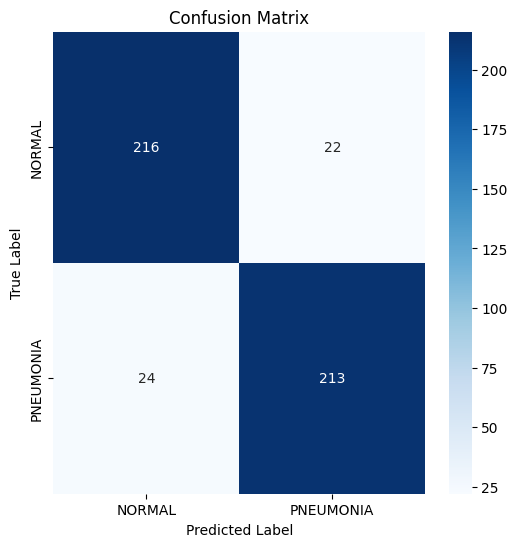

accuracy: 0.9032
recall: 0.8987
precision: 0.9064
f1: 0.9025
roc_auc: 0.9031


In [50]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Zakładamy, że obiekt `history` został zwrócony przez model.fit
# history = model.fit(...)

# Wykres accuracy i loss dla danych treningowych oraz walidacyjnych
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# Ocena modelu na zbiorze testowym
test_loss, test_accuracy = model_bal.evaluate(test_generator)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test Loss: {:.4f}".format(test_loss))

# Obliczenie macierzy pomyłek
# Upewnij się, że test_generator nie miesza kolejności, resetujemy go
test_generator.reset()
predictions = model_bal.predict(test_generator)
# Zakładamy, że mamy klasyfikację binarną z funkcją aktywacji sigmoid
y_pred = (predictions > 0.5).astype(int).ravel()
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(6, 6))
class_names = list(test_generator.class_indices.keys())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print('accuracy: {:.4f}'.format(accuracy_score(y_true, y_pred)))
print('recall: {:.4f}'.format(recall_score(y_true, y_pred)))
print('precision: {:.4f}'.format(precision_score(y_true, y_pred)))
print('f1: {:.4f}'.format(f1_score(y_true, y_pred)))
print('roc_auc: {:.4f}'.format(roc_auc_score(y_true, y_pred)))


In [60]:
#dane w skali szarości

import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from PIL import Image

def get_image_paths(base_dir, subsets=['train', 'val', 'test'], classes=['NORMAL', 'PNEUMONIA']):
    """
    Przegląda podfoldery (train, val, test) oraz podfoldery odpowiadające klasom,
    zbiera ścieżki do obrazów i zwraca DataFrame z kolumnami: 'filepath' i 'label'.
    """
    image_paths = []
    labels = []
    for subset in subsets:
        for cls in classes:
            folder = os.path.join(base_dir, subset, cls)
            if not os.path.exists(folder):
                print(f"Folder {folder} nie istnieje, pomijam.")
                continue
            for fname in os.listdir(folder):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(folder, fname))
                    labels.append(cls)
    return pd.DataFrame({'filepath': image_paths, 'label': labels})

def convert_and_save_image(src_path, dst_path):
    """
    Otwiera obraz z src_path, konwertuje do skali szarości i zapisuje do dst_path.
    """
    try:
        img = Image.open(src_path)
        img_gray = img.convert('L')  # 'L' oznacza skalę szarości
        img_gray.save(dst_path)
    except Exception as e:
        print(f"Błąd przy przetwarzaniu {src_path}: {e}")

# Ścieżka do oryginalnego zbioru danych – zmień na właściwą ścieżkę
base_dir = '/content/chest-xray-pneumonia/chest_xray'

# Łączenie wszystkich obrazów ze zbiorów train, val, test
df = get_image_paths(base_dir, subsets=['train', 'val', 'test'])
print("Liczba obrazów przed balansowaniem:", len(df))
print(df['label'].value_counts())

# Balansowanie: wybieramy dla każdej klasy tyle próbek, ile wynosi liczba obrazów w mniejszej klasie
min_count = df['label'].value_counts().min()
df_balanced = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min_count, random_state=42))
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print("\nLiczba obrazów po balansowaniu:")
print(df_balanced['label'].value_counts())

# Podział na zbiory: 70% trening, 15% walidacja, 15% test
train_df, temp_df = train_test_split(df_balanced, test_size=0.3, random_state=42, stratify=df_balanced['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print("\nLiczba próbek w nowych zbiorach:")
print("Trening:", len(train_df))
print("Walidacja:", len(val_df))
print("Test:", len(test_df))

# Definiowanie nowej struktury wyjściowej – obrazy przetworzone do skali szarości
output_base_dir = 'output_dataset'
splits = {'train': train_df, 'val': val_df, 'test': test_df}
classes = ['NORMAL', 'PNEUMONIA']

# Tworzenie katalogów wyjściowych
for split_name in splits.keys():
    for cls in classes:
        os.makedirs(os.path.join(output_base_dir, split_name, cls), exist_ok=True)

# Przetwarzanie obrazów: konwersja do skali szarości i zapis do odpowiednich folderów
for split_name, df_split in splits.items():
    for idx, row in df_split.iterrows():
        src_path = row['filepath']
        label = row['label']
        filename = os.path.basename(src_path)
        dst_path = os.path.join(output_base_dir, split_name, label, filename)
        convert_and_save_image(src_path, dst_path)

print("Przetwarzanie i zapis obrazów zakończone.")


Liczba obrazów przed balansowaniem: 5856
label
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64

Liczba obrazów po balansowaniu:
label
NORMAL       1583
PNEUMONIA    1583
Name: count, dtype: int64

Liczba próbek w nowych zbiorach:
Trening: 2216
Walidacja: 475
Test: 475


<ipython-input-60-79cf57dbecb5>:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min_count, random_state=42))


Przetwarzanie i zapis obrazów zakończone.


Liczba obrazów w poszczególnych zbiorach:
train: {'NORMAL': 1108, 'PNEUMONIA': 1108}
val: {'NORMAL': 237, 'PNEUMONIA': 238}
test: {'NORMAL': 238, 'PNEUMONIA': 237}


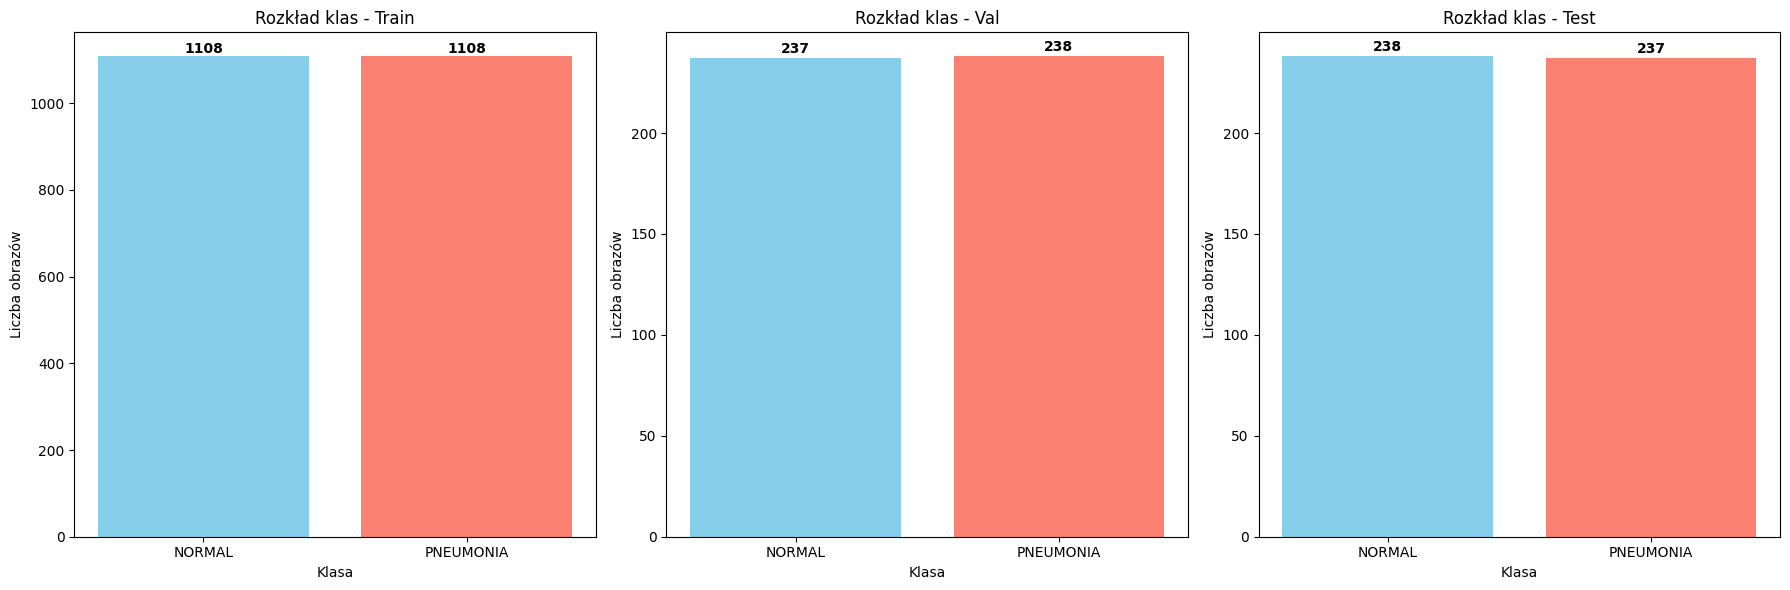

In [61]:
#wykresy zawartosci  danych GREYSCALE
import os
import matplotlib.pyplot as plt

# Ustaw ścieżkę do głównego folderu ze zbiorem danych
base_dir = output_base_dir #'/content/chest-xray-pneumonia/chest_xray'

subsets = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

# Słownik do przechowywania liczby obrazów dla każdej klasy w każdym zbiorze
counts = {}

for subset in subsets:
    counts[subset] = {}
    for cls in classes:
        folder = os.path.join(base_dir, subset, cls)
        if os.path.exists(folder):
            # Liczymy tylko pliki z rozszerzeniami obrazów
            num_files = len([f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            counts[subset][cls] = num_files
        else:
            counts[subset][cls] = 0

print("Liczba obrazów w poszczególnych zbiorach:")
for subset in counts:
    print(f"{subset}: {counts[subset]}")

# Generowanie wykresów słupkowych dla każdego zbioru
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, subset in zip(axes, subsets):
    cls_names = list(counts[subset].keys())
    cls_counts = list(counts[subset].values())

    bars = ax.bar(cls_names, cls_counts, color=['skyblue', 'salmon'])
    ax.set_title(f'Rozkład klas - {subset.capitalize()}')
    ax.set_xlabel('Klasa')
    ax.set_ylabel('Liczba obrazów')

    # Dodaj etykiety z liczbą obrazów nad słupkami
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 1, str(height),
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [69]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import glob
import pandas as pd

# Ustawienia ścieżek do danych – upewnij się, że struktura katalogów jest następująca:
# dataset/
# ├── train/
# │   ├── NORMAL/
# │   └── PNEUMONIA/
# ├── validation/
# │   ├── NORMAL/
# │   └── PNEUMONIA/
# └── test/
#     ├── NORMAL/
#     └── PNEUMONIA/
base_dir = output_base_dir #'/content/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Parametry przetwarzania obrazów
img_width, img_height = 150, 150  # rozmiar wejściowy obrazu
batch_size = 32

# Przygotowanie generatorów danych z augmentacją dla treningu
train_datagen = ImageDataGenerator(
    rescale=1./255,          # normalizacja pikseli
    rotation_range=15,       # losowe obroty
    width_shift_range=0.15,   # przesunięcia w poziomie
    height_shift_range=0.15,  # przesunięcia w pionie
    shear_range=0.15,         # transformacja skośna
    zoom_range=0.15,          # powiększenia
    horizontal_flip=False,    # odbicie lustrzane
    vertical_flip=False,
    fill_mode='nearest'
)

# Dla zbiorów walidacyjnego i testowego używamy tylko skalowania
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generatory danych
'''
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",  # Specify the column containing image paths
    y_col="label",  # Specify the column containing labels
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = True,               # True - zdjęcia będą losowo mieszane w całym zbiorze
    class_mode='binary'
)
'''
train_generator = train_datagen.flow_from_dataframe(
    pd.concat([train_df, train_df]),
    x_col="filepath",  # Specify the column containing image paths
    y_col="label",  # Specify the column containing labels
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = True,               # True - zdjęcia będą losowo mieszane w całym zbiorze
    class_mode='binary'
)
validation_generator = validation_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",  # Specify the column containing image paths
    y_col="label",  # Specify the column containing labels
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filepath",  # Specify the column containing image paths
    y_col="label",  # Specify the column containing labels
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
)

# Budowa modelu CNN
model_bal_grayscale = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # klasyfikacja binarna
])

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    #patience=4,          # Number of epochs to wait before stopping
    patience=5,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)

model_checkpoint = ModelCheckpoint(
    filepath='pneumonia_classification_model_bal_grayscale.keras',  # Use .keras extension
    monitor='val_accuracy',       # Metric to monitor
    save_best_only=True,          # Save only the best model
    mode='max'                    # Maximize the monitored metric
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,          # Reduce learning rate by a factor of 0.1
    #patience=3           # Number of epochs to wait before reducing LR
    patience=5           # Number of epochs to wait before reducing LR
)

# Kompilacja modelu
model_bal_grayscale.compile(
    loss='binary_crossentropy',
    #optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Wyświetlenie podsumowania modelu
model_bal_grayscale.summary()

# Trening modelu
epochs = 30 #20
history = model_bal_grayscale.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Add callbacks here
)

# Ewaluacja na zbiorze testowym
test_loss, test_accuracy = model_bal_grayscale.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Dokładność na zbiorze testowym:', test_accuracy)

# Zapisanie modelu do pliku
model_bal_grayscale.save('pneumonia_classification_model_bal_grayscale.keras')
#model_summary(model_bal, X_val_bal, y_val_bal)

Found 4432 validated image filenames belonging to 2 classes.
Found 475 validated image filenames belonging to 2 classes.
Found 475 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1024)                │       6,423,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,927,041 (26.42 MB)

 Trainable params: 6,927,041 (26.42 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 84s 574ms/step - accuracy: 0.5912 - loss: 0.6464 - val_accuracy: 0.8594 - val_loss: 0.3635 - learning_rate: 1.0000e-04
Epoch 2/30
  1/138 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7188 - loss: 0.4619

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7188 - loss: 0.4619 - val_accuracy: 0.8482 - val_loss: 0.3833 - learning_rate: 1.0000e-04
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 130s 535ms/step - accuracy: 0.8243 - loss: 0.3966 - val_accuracy: 0.8638 - val_loss: 0.3342 - learning_rate: 1.0000e-04
Epoch 4/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9062 - loss: 0.2720 - val_accuracy: 0.8951 - val_loss: 0.2971 - learning_rate: 1.0000e-04
Epoch 5/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 81s 565ms/step - accuracy: 0.8885 - loss: 0.2955 - val_accuracy: 0.8817 - val_loss: 0.3078 - learning_rate: 1.0000e-04
Epoch 6/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8438 - loss: 0.3297 - val_accuracy: 0.8281 - val_loss: 0.3710 - learning_rate: 1.0000e-04
Epoch 7/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 142s 598ms/step - accuracy: 0.8843 - loss: 0.2917 - val_accuracy: 0.8616 - val_loss: 0.3186 - learning_rate: 1.0000e-04
Epoch 8/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accura

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[0.7950354]]
0.7950354
Predykcja (prawdopodobieństwo Pneumonii): 0.7950354
Wynik: Pneumonia


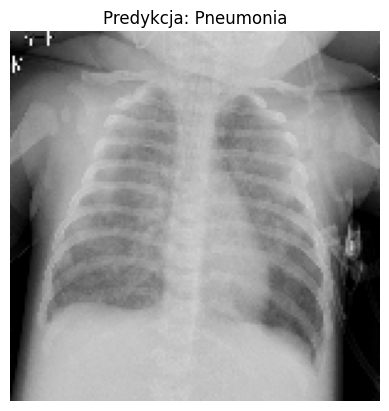

In [71]:
import keras
from keras import ops
from keras import utils
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Ścieżka do wybranego obrazu z zestawu danych
sample_image_path = '/content/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg'

# Wczytanie obrazu i przeskalowanie do wymiarów modelu
sample_img = keras.utils.load_img(sample_image_path, target_size=(img_width, img_height))
#sample_img = sample_img.convert('L')  # 'L' oznacza skalę szarości
sample_img_array = keras.utils.img_to_array(sample_img)
sample_img_array = np.expand_dims(sample_img_array, axis=0)
sample_img_array /= 255.0

# Predykcja dla wybranego obrazu
prediction = model_bal_grayscale.predict(sample_img_array)[0][0]
print( model_bal_grayscale.predict(sample_img_array))
print(prediction)
print("Predykcja (prawdopodobieństwo Pneumonii):", prediction)
if prediction > 0.5:
    print("Wynik: Pneumonia")
else:
    print("Wynik: Normal")

# Wyświetlenie obrazu wraz z wynikową predykcją
plt.imshow(sample_img)
plt.title("Predykcja: " + ("Pneumonia" if prediction > 0.5 else "Normal"))
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[0.78905296]]
0.78905296
Predykcja (prawdopodobieństwo Pneumonii): 0.78905296
Wynik: Pneumonia


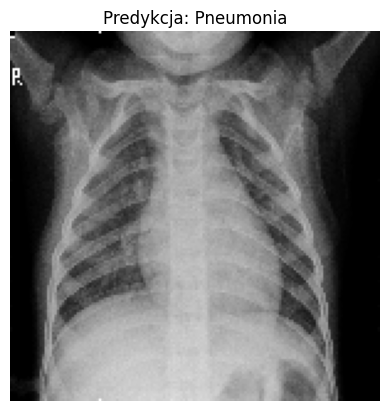

In [73]:
import keras
from keras import ops
from keras import utils
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Ścieżka do wybranego obrazu z zestawu danych
sample_image_path = '/content/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg'

# Wczytanie obrazu i przeskalowanie do wymiarów modelu
sample_img = keras.utils.load_img(sample_image_path, target_size=(img_width, img_height))
#sample_img = sample_img.convert('L')  # 'L' oznacza skalę szarości
sample_img_array = keras.utils.img_to_array(sample_img)
sample_img_array = np.expand_dims(sample_img_array, axis=0)
sample_img_array /= 255.0

# Predykcja dla wybranego obrazu
prediction = model_bal_grayscale.predict(sample_img_array)[0][0]
print( model_bal_grayscale.predict(sample_img_array))
print(prediction)
print("Predykcja (prawdopodobieństwo Pneumonii):", prediction)
if prediction > 0.5:
    print("Wynik: Pneumonia")
else:
    print("Wynik: Normal")

# Wyświetlenie obrazu wraz z wynikową predykcją
plt.imshow(sample_img)
plt.title("Predykcja: " + ("Pneumonia" if prediction > 0.5 else "Normal"))
plt.axis('off')
plt.show()

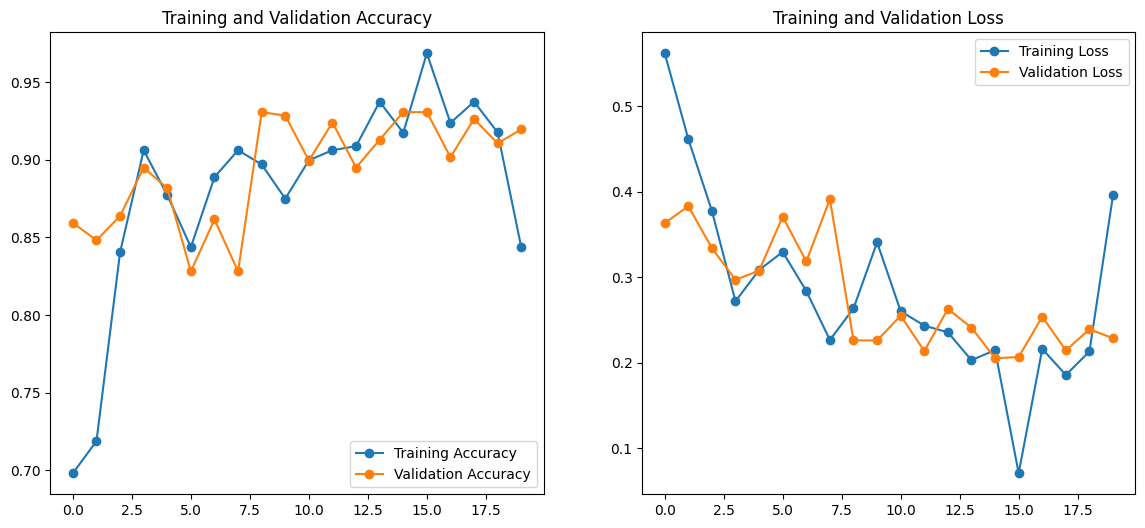

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 345ms/step - accuracy: 0.9249 - loss: 0.1717
Test Accuracy: 92.42%
Test Loss: 0.1806
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step
Confusion Matrix:
[[219  19]
 [ 17 220]]


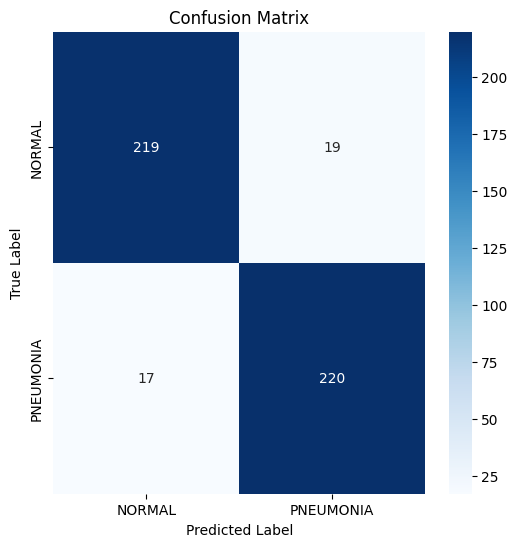

accuracy: 0.9242
recall: 0.9283
precision: 0.9205
f1: 0.9244
roc_auc: 0.9242


In [74]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Zakładamy, że obiekt `history` został zwrócony przez model.fit
# history = model.fit(...)

# Wykres accuracy i loss dla danych treningowych oraz walidacyjnych
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# Ocena modelu na zbiorze testowym
test_loss, test_accuracy = model_bal_grayscale.evaluate(test_generator)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test Loss: {:.4f}".format(test_loss))

# Obliczenie macierzy pomyłek
# Upewnij się, że test_generator nie miesza kolejności, resetujemy go
test_generator.reset()
predictions = model_bal_grayscale.predict(test_generator)
# Zakładamy, że mamy klasyfikację binarną z funkcją aktywacji sigmoid
y_pred = (predictions > 0.5).astype(int).ravel()
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(6, 6))
class_names = list(test_generator.class_indices.keys())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print('accuracy: {:.4f}'.format(accuracy_score(y_true, y_pred)))
print('recall: {:.4f}'.format(recall_score(y_true, y_pred)))
print('precision: {:.4f}'.format(precision_score(y_true, y_pred)))
print('f1: {:.4f}'.format(f1_score(y_true, y_pred)))
print('roc_auc: {:.4f}'.format(roc_auc_score(y_true, y_pred)))
